<img src="https://i.imgur.com/DKn4ofz.png">

<center><h1> RSNA Screening Mammography Breast Cancer Detection </h1></center>
<center><h2> - Data Explore - </h2></center>

> 📌 **Scope**: The goal of this competition is to identify cases of *breast cancer* in mammograms from screening exams. It is important to have True Positives (TP) as high as possible, but False Positives (FP) also have downsides for patients. Hence the **Precission should be as high as possible**.


### ○ Libraries

In [1]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless"
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d05f5822e9478e57b8596df2fed3b1b3cbdd68704a9314b98a916a7619017d15
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attem

In [2]:
# mount 
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir(r"/content/drive/MyDrive/kaggle/kaggle_rsna2022/")


Mounted at /content/drive


Notebook Color Schemes:


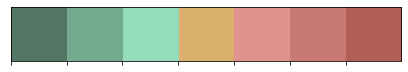

In [3]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C", 
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

### 🐝 W&B Fork & Run

In order to run this notebook you will need to input your own **secret API key** within the `! wandb login $secret_value_0` line. 

🐝**How do you get your own API key?**

Super simple! Go to **https://wandb.ai/site** -> Login -> Click on your profile in the top right corner -> Settings -> Scroll down to API keys -> copy your very own key (for more info check [this amazing notebook for ML Experiment Tracking on Kaggle](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases)).

<center><img src="https://i.imgur.com/fFccmoS.png" width=500></center>

In [4]:
# 🐝 Secrets
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("wandb")

! wandb login cf6a804285a3c944eb8be0502cfd4f532e517931 

### ○ Helpers

In [5]:
# === General Functions ===

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path, data_type="dataset"):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='Otto', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type=data_type)
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [6]:
os.listdir(os.getcwd())

['.git',
 'protos',
 'input',
 '.gitignore',
 'wandb',
 'rsna_eda.ipynb',
 'train_path.csv']

In [7]:
# 🐝 Bonus: Cover Photo
run = wandb.init(project='RSNA_Breast_Cancer', name='CoverPhoto', config=CONFIG)
#cover = plt.imread("input/rsna-breast-cancer-helper-data/DKn4ofz.png")
#wandb.log({"cover": wandb.Image(cover)})
#wandb.finish()

In [8]:
train = pd.read_csv("input/rsna-breast-cancer-detection/train.csv")

# Get image path
# Example path: 'input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm'
base_path = "input/rsna-breast-cancer-detection/train_images/"
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".dcm")
    
train["path"] = all_paths

100%|██████████| 54706/54706 [00:14<00:00, 3655.69it/s]


# 1. Brief overview

**Q**: How does the data look like? What is the general feel of the numbers?

**A**: We have the following info:
* `site_id` - There are 2 total hospitals from where the records were gathered, split roughly 50-50
* `patient_id` - The unique identifier of the patient. There are **11.913** total patients
* `image_id` - The unique identidier of the image. There are **54.706** unique images in train. *Each patient has an average of 4.5 breast scans* (with 4 being the least number of scans and 14 being the maximum number of scans per patient).
* `laterality` - L is for the left breast, R is for the right. There are slightly more images for the R (right) breast -> 27,439 than for the L (left) breast -> 27,267.

In [9]:
print(clr.S+"Records gathered in Site 1:"+clr.E, train["site_id"].value_counts().values[0], "\n"+
      clr.S+"Records gathered in Site 2:"+clr.E, train["site_id"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Total unique patients:"+clr.E, train["patient_id"].nunique())
print("-------------------------------------------------")
print(clr.S+"Total unique images:"+clr.E, train["image_id"].nunique())
print("-------------------------------------------------")
print(clr.S+"Statistics: Images per Patient"+clr.E)
print(train.groupby("patient_id")["image_id"].count().reset_index().describe()["image_id"])
print("-------------------------------------------------")
print(clr.S+"Image records count per laterality (R):"+clr.E, train["laterality"].value_counts().values[0], "\n"+
      clr.S+"Image records count per laterality (L):"+clr.E, train["laterality"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Image records count per View:"+clr.E)
print(train["view"].value_counts())

Records gathered in Site 1: 29519 
Records gathered in Site 2: 25187
-------------------------------------------------
Total unique patients: 11913
-------------------------------------------------
Total unique images: 54706
-------------------------------------------------
Statistics: Images per Patient
count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         14.000000
Name: image_id, dtype: float64
-------------------------------------------------
Image records count per laterality (R): 27439 
Image records count per laterality (L): 27267
-------------------------------------------------
Image records count per View:
MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64


**Q**: What does `view` mean? How many images per view do we have? Is there a noticable difference between images and views?

**A**: So here are the main takeaways:
* `view` - The orientation of the image. The values for this variable are:
    * MLO (mediolateral oblique) - 27903 images. 
    * CC (craniocaudal) - 26765 images.
    * AT (axillary tail) - 19 images.
    * LM (latero-medial) - 10 images.
    * ML (medio-lateral) - 8 images.
    * LMO (latero-medial oblique) - 1 images.
* no, I do not see any noticeable difference between the images (I am not a doctor tho).

In [10]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='view_sample', config=CONFIG)

In [11]:
def show_view(view_name, sample_size):
    
    if view_name != "LMO":
        # Get image info
        data = train[train["view"]==view_name].sample(sample_size, random_state=24)
        image_path = data["path"].to_list()

        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []

        for k, path in enumerate(image_path):
            axs[k].set_title(f"{k+1}. {view_name}", 
                             fontsize = 16, color = my_colors[0], weight='bold')

            img = pydicom.dcmread(path).pixel_array
            wandb_images.append(wandb.Image(img))
            #axs[k].imshow(img, cmap="turbo")
            
            axs[k].imshow(img)
            axs[k].axis("off")

        plt.tight_layout()
        plt.show()

        # 🐝 Log Image to W&B
        wandb.log({f"{view_name}": wandb_images})
    else:
        path = train[train["view"]=="LMO"]["path"].item()
        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []
        img = pydicom.dcmread(path).pixel_array
        wandb_images.append(wandb.Image(img))
        #axs[0].imshow(img, cmap="turbo")
        
        axs[0].imshow(img)
        axs[0].set_title(f"1. LMO", 
                         fontsize = 16, color = my_colors[0], weight='bold')
        axs[0].axis("off")
        axs[1].axis("off")
        axs[2].axis("off")
        axs[3].axis("off")
        axs[4].axis("off")

        plt.tight_layout()
        plt.show()
        
        wandb.log({f"LMO": wandb_images})

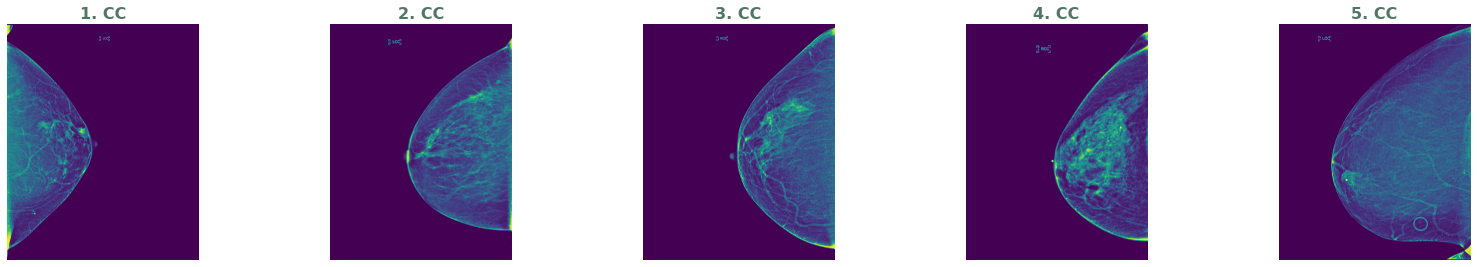

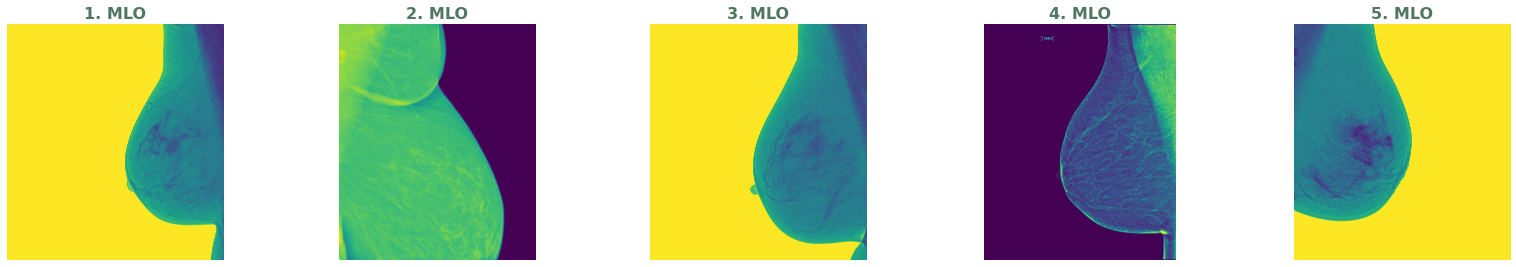

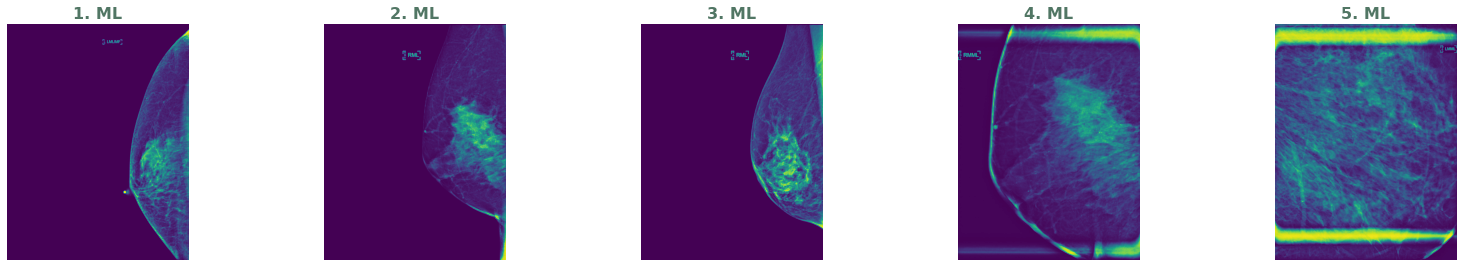

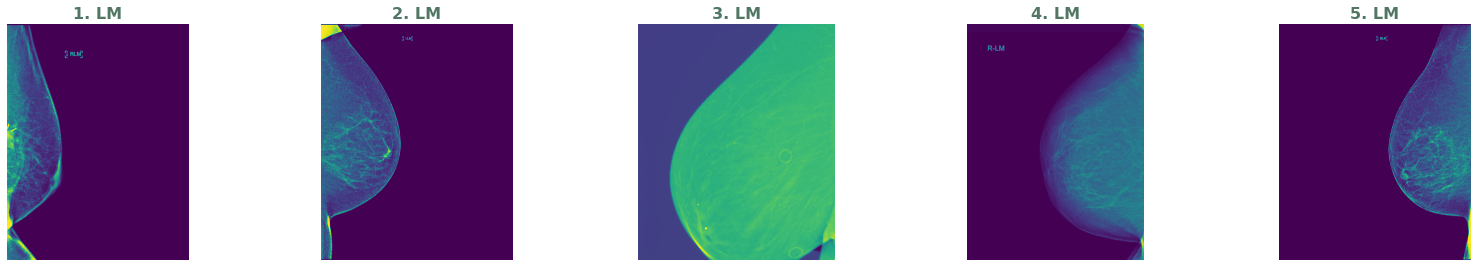

In [ ]:
for view_name in train["view"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_view(view_name, sample_size=5)

In [ ]:
wandb.finish()

**Q**: What is the age of the patients? Is the age spectrum wide (with patients from all categories) or is it narrowed on a specific age group?

**A**: Looks like overall our patients are part of a more senior age group:
* `age` - The patient's age in years. The **average age is 58 years old**, with the vast majority of the patients having between 50 and 65 years old. There are a few outliers with very young patients (26-30 years old), as well as a few more senior patients (89 years old).

In [ ]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='age_hist', config=CONFIG)

In [ ]:
# Plot
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(a=train["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
             ax=a0)

a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=84, y=0.037, s="max: 89", size=17, color="black", weight="bold")

sns.boxenplot(x=train["age"], ax=a1, color=my_colors[2])

plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [ ]:
# 🐝 Log into dashboard
create_wandb_hist(x_data=train["age"], 
                  x_name="Age",
                  title="Age Distribution",
                  log="age_hist")

**Q**: What about on cancer level? Are the distributions different?

**A**: It looks like the minimum and average age have shifted. The *youngest patient to have cancer is 38 years old*, while the *mean of those patients is 63* years old.

In [ ]:
# Plot
f, (a0, a1) = plt.subplots(1, 2, figsize=(24, 12))
sns.distplot(a=train[train["cancer"]==0]["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
             ax=a0)
a0.set_title("No Cancer Present", weight="bold", size=20)
a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


sns.distplot(a=train[train["cancer"]==1]["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[2]},
             kde_kws={"color": my_colors[2], "lw": 5, "alpha": 0.7},
             ax=a1)
a1.set_title("Cancer Present", weight="bold", size=20)
a1.axvline(x=63, ls=":", lw=2, color="black")
a1.text(x=63.5, y=0.018, s="mean: 63", size=17, color="black", weight="bold")
a1.axvline(x=38, ls=":", lw=2, color="black")
a1.text(x=38.5, y=0.008, s="min: 38", size=17, color="black", weight="bold")
a1.axvline(x=89, ls=":", lw=2, color="black")
a1.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [ ]:
# 🐝 Log into dashboard
create_wandb_hist(x_data=train[train["cancer"]==1]["age"], 
                  x_name="Age",
                  title="Age Distribution - patients with cancer",
                  log="age_hist_cancer")

In [ ]:
wandb.finish()

**Q**: Are there many cases with implants? How do these implants show in the scans?

**A**: Looks like **there are very few records with implants**. Some scans clearly show the implant, however in others it is not visible (at least to my unexpert eye):
* `implant` - Flag whether or not the patient has breast implants. For `site`=1 we have this info on patient level, for `site`=2 we have this info at image level. There are **only 1477 images** that contain implants.

In [ ]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='implant_sample', config=CONFIG)

In [ ]:
def show_images(col, col_flag, sample_size, cancer_flag=0):
    
    # Get image info
    data = train[train[col]==col_flag].sample(sample_size, random_state=24)
    if cancer_flag==1:
        data = train[train.cancer==1]
        data = data[data[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["path"].to_list()

    # Plot
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", 
                         fontsize = 14, color = my_colors[0], weight='bold')

        img = pydicom.dcmread(path).pixel_array
        wandb_images.append(wandb.Image(img))
        #axs[k].imshow(img, cmap="turbo")
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

    # 🐝 Log Image to W&B
    wandb.log({f"{col}_{col_flag}": wandb_images})

Records with no implants: 53229 
Records with implants: 1477 



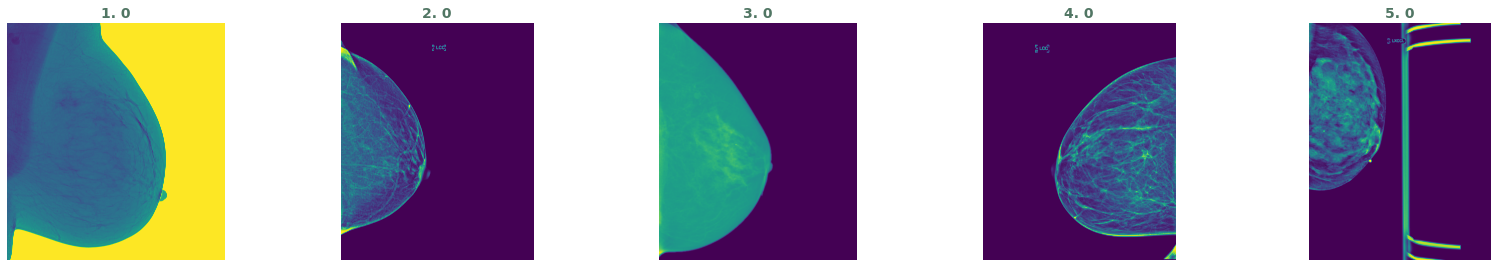

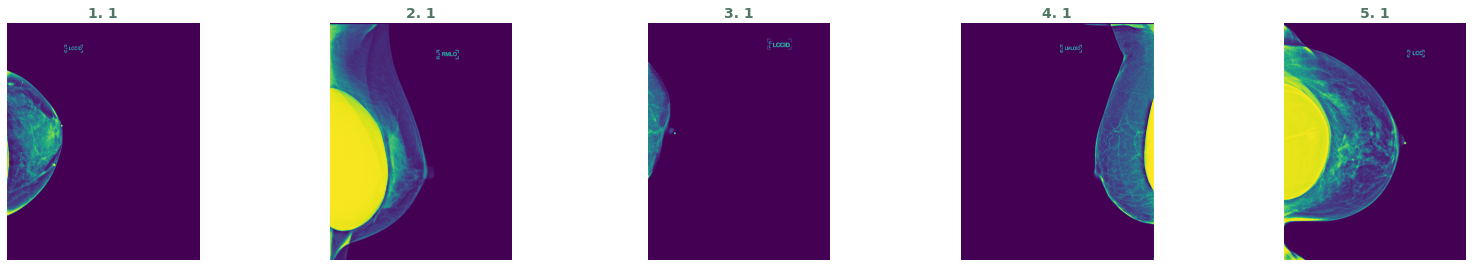

In [ ]:
print(clr.S+"Records with no implants:"+clr.E, train["implant"].value_counts().values[0], "\n"+
      clr.S+"Records with implants:"+clr.E, train["implant"].value_counts().values[1], "\n")

for implant_flag in train["implant"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_images(col="implant", col_flag=implant_flag, sample_size=5)

In [ ]:
wandb.finish()

# 2. Target Explore

**Q**: How many cases with cancer are there? What can the variables given only for `train` dataset tell us?

* `cancer` - our **target** variable. 1 if the image has cancer detected, 0 otherwise. The class imbalance is very big, with **only 2% of images being cancer positive**.
* `invasive` - for cases when cancer was present, another flag that states if the cancer was invasive or not. Around 70% of cases that had cancer were invasive.

In [ ]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='cancer_explore', config=CONFIG)

In [ ]:
print(clr.S+"Records with no cancer:"+clr.E, train["cancer"].value_counts().values[0], "\n"+
      clr.S+"Records with cancer:"+clr.E, train["cancer"].value_counts().values[1], "\n")

for cancer_flag in train["cancer"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_images(col="cancer", col_flag=cancer_flag, sample_size=5)

In [ ]:
print(clr.S+"Records with invasion:"+clr.E, train[train.cancer==1]["invasive"].value_counts().values[0], "\n"+
      clr.S+"Records with no invasion:"+clr.E, train[train.cancer==1]["invasive"].value_counts().values[1], "\n")

for invasive_flag in train["invasive"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_images(col="invasive", col_flag=invasive_flag, sample_size=5, cancer_flag=1)

**Q**: How many cases were difficult? Are the scans different between cases?

**A**: Around 16% of cases proved to be difficult:
* `difficult_negative_case` - True if the speciffic case was particularly difficult. There have been around 7705 cases that were exceptionally difficult in the train dataset. This variable is not provided for the test set.

In [ ]:
print(clr.S+"Cases not particularly difficult:"+clr.E, train["difficult_negative_case"].value_counts().values[0], "\n"+
      clr.S+"Cases particularly difficult:"+clr.E, train["difficult_negative_case"].value_counts().values[1], "\n")

for difficult_flag in train["difficult_negative_case"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_images(col="difficult_negative_case", col_flag=difficult_flag, sample_size=5, cancer_flag=0)

In [ ]:
wandb.finish()

# 3. Train Preprocessing

Just a little data preparation before going into the models.

## 3.1 Label Encoding
* `laterality`:
    * 0: L (Left)
    * 1: R (Right)
* `view`:
    * 0: AT (axillary tail)
    * 1: CC (craniocaudal)
    * 2: LM (latero-medial)
    * 3: LMO (latero-medial oblique) 
    * 4: ML (medio-lateral)
    * 5: MLO (mediolateral oblique)

In [ ]:
# Keep only columns in test + target variable
train = train[["patient_id", "image_id", "laterality", "view", "age", "implant", "path", "cancer"]]

# Encode categorical variables
le_laterality = LabelEncoder()
le_view = LabelEncoder()

train['laterality'] = le_laterality.fit_transform(train['laterality'])
train['view'] = le_view.fit_transform(train['view'])

train.head()

## 3.2 Impute

**!!! Note**: `age` column has 37 missing values (duplicated for some patients). We will impute it with the mean and then *normalize*.

In [ ]:
print(clr.S+"Number of missing values in Age:"+clr.E, train["age"].isna().sum())
train['age'] = train['age'].fillna(58)

## 3.3 Save Artifact

In [ ]:
# Save new dataset
train.to_csv("train_path.csv", index=False)

# 🐝 Save Artifacts
save_dataset_artifact(run_name="save_train_prep", 
                      artifact_name="train_prep",
                      path="input/rsna-breast-cancer-helper-data/train_path.csv",
                      data_type="dataset")

Artifact has been saved successfully.


---------------
<img src="https://i.imgur.com/4MyF4Zh.jpg">

<center><h2> - PyTorch Baseline - </h2></center>

### ○ (more) Libraries

In [ ]:
!pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done


In [ ]:
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
# Seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

# Read in Data
train = pd.read_csv("input/rsna-breast-cancer-helper-data/train_path.csv")

Device available now: cpu


In [ ]:
# Sample down for dev
# train = train.sample(n=500, random_state=13).reset_index(drop=True)
# train["cancer"].value_counts()

### ○ Params

In [ ]:
# ----- GLOBAL PARAMS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# -------------------------

# 4. PyTorch Dataset

In [ ]:
class RSNADataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation (custom for each dataset type)
        if is_train:
            self.transform = Compose([RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batcj at a time.'''
        
        # Select path and read image
        image_path = self.dataframe['path'][index]
        image = pydicom.dcmread(image_path).pixel_array.astype(np.float32)
        
        # For this image also import .csv information
        csv_data = np.array(self.dataframe.iloc[index][csv_columns].values, 
                            dtype=np.float32)
        # Apply transforms
        transf_image = self.transform(image=image)['image']
        # Change image from 1 channel (B&W) to 3 channels
        transf_image = np.concatenate([transf_image, transf_image, transf_image], axis=0)
        
        # Return info
        if self.is_train:
            return {"image": transf_image, 
                    "meta": csv_data, 
                    "target": self.dataframe['cancer'][index]}
        else:
            return {"image": transf_image, 
                    "meta": csv_data}

In [ ]:
def data_to_device(data):
    
    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

### ◾ Sanity Check

In [ ]:
# Sample data
sample_df = train.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Meta:" + clr.E, meta, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)

FileNotFoundError: ignored

# 5. Network

## 5.1 ResNet50

* **ResNet** - stands for Residual Network.
    * Residual Networks - form networks **by stacking residual blocks**.
    * [Residual Block](https://towardsdatascience.com/resnets-residual-blocks-deep-residual-learning-a231a0ee73d2#:~:text=A%20residual%20block%20is%20a,layer%20in%20the%20main%20path.) - a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block. This method is also called **by-pass** or **skip-connection**.
<center><img src="https://miro.medium.com/max/828/0*TyvNvZhiuzEbIiXw.webp" width=700></center>
* It's a *special* CNN introduced in 2015
* Many ResNets - ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 (numbers stand for how many layers)
* **Deeper layers** (more convolutions), but without the [vanishing gradient problem](https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html).
* The **residual blocks create an identity mapping** to activations *earlier* in the network to thwart the performance degradation problem associated with deep neural architectures.
* The **by-pass connections help to address the problem of vanishing and exploding gradients**.

<center><img src="https://i.imgur.com/YXA2OVM.jpg" width=800></center>

In [ ]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

### ◾ Sanity Check

> How does it work:
<center><img src="https://i.imgur.com/ChkZ53p.jpg" width=700></center>

In [ ]:
# Load Model
model_example = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = model_example(image, meta, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(clr.S+'Loss:'+clr.E, loss.item())

## 5.2 EffNet

* The issue with ResNet & other architectures:
    * CNNs are usually developed at a **fixed resource cost** and then scaled up when more resources are available.
    * **The scaling up** - increase arbitrary the depth or width of the CNN, then manually tune.
    * This is **not optimal**.
* **[EffNets](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) try to solve this issue** through a more "principled" method of scaling up.
* They use a *compound coefficient* to scale up CNNs in a more structured manner.
    * uniformly scale each dimension (width, height, resolution) with a **fixed set of scaling coefficients**.
    * this *balanced* scaling is much more efficient than scaling only 1 dimension at a time.
* They also use **AutoML**:
    * Automated Machine Learning
    * uses Reinforcement Learning
* The relationship between different scaling dimensions is found through a **Grid Search** (to determine the appropriate scaling coeff for each dimension). These coefficients are then applied to scale up the *baseline network* (from which we can then expand).
<center><img src="https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png" width=600></center>
* Many EffNets: B0, B1, B2, B3, B4, B5, B6, B7.
    * smaller than other architectures - the number of parameters are smaller
    * but higher efficiency
<center><img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png" width=400></center>

In [ ]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

### ◾ Sanity Check

> How does it work:
<center><img src="https://i.imgur.com/vdonWT7.jpg" width=700></center>

In [ ]:
# Load Model
model_example2 = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = model_example2(image, meta, prints=True)

# Criterion example
criterion_example = nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(clr.S+'Loss:'+clr.E, loss.item())

# 6. Training ...

### 🎗️ Small function to save in an external file

In [ ]:
1408+250

In [ ]:
def add_in_file(text, f):
    
    with open(f'logs_{VERSION}.txt', 'a+') as f:
        print(text, file=f)

### 🎗️ Main Training Function

> How does it work:
<center><img src="https://i.imgur.com/7MWwg9W.png" width=800></center>

In [ ]:
def train_folds(model, train_original):
    # Creates a .txt file that will contain the logs
    # logs == what we also print to console
    f = open(f"logs_{VERSION}.txt", "w+")
    
    # Split in folds
    group_fold = GroupKFold(n_splits = FOLDS)

    # Generate indices to split data into training and test set.
    k_folds = group_fold.split(X = np.zeros(len(train_original)), 
                               y = train_original['cancer'], 
                               groups = train_original['patient_id'].tolist())
    
    # For each fold
    for i, (train_index, valid_index) in enumerate(k_folds):
        
        print(clr.S+f"---------- Fold: {i+1} ----------"+clr.E)
        add_in_file(f"---------- Fold: {i+1} ----------", f)
        
        # 🐝 W&B Tracking
        RUN_CONFIG = CONFIG.copy()
        params = dict(model=MODEL, 
                      version=VERSION,
                      fold=i,
                      epochs=EPOCHS, 
                      batch=BATCH_SIZE1,
                      lr=LR,
                      weight_decay=WD)
        RUN_CONFIG.update(params)
        run = wandb.init(project='RSNA_Breast_Cancer', config=RUN_CONFIG)

        wandb.watch(model, log_freq=100) # 🐝

        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE

        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, 
                                     weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = RSNADataset(train_data, vertical_flip, horizontal_flip, 
                            is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip,
                            is_train=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, 
                                  shuffle=True, num_workers=WORKERS)
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, 
                                  shuffle=False, num_workers=WORKERS)


        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            # For each batch
            for k, data in tqdm(enumerate(train_loader)):
                # Save them to device
                image, meta, targets = data_to_device(data)

                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                out = model(image, meta)
                loss = criterion(out, targets.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item()
                wandb.log({"train_loss": loss.item()}, step=epoch) # 🐝
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)
            wandb.log({"train_acc": train_acc}) # 🐝


            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), 
                                      device=DEVICE, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, data in tqdm(enumerate(valid_loader)):
                    # Save them to device
                    image, meta, targets = data_to_device(data)

                    out = model(image, meta)
                    pred = torch.sigmoid(out)
                    valid_preds[k*image.shape[0] : k*image.shape[0] + image.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, 
                                           torch.round(valid_preds.cpu()))
                wandb.log({"valid_acc": valid_acc}) # 🐝
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, 
                                          valid_preds.cpu())
                wandb.log({"valid_roc": valid_roc}) # 🐝

                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                       train_losses, train_acc, valid_acc, valid_roc)
                add_in_file(final_logs,f)
                print(final_logs)


                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        add_in_file(stop_logs, f)
                        print(stop_logs)
                        break


        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, image, targets
        gc.collect()
        
        # 🐝 Experiment End for this fold
        wandb.finish()

### 🎗️ Experimenting

> 📌 **Note**: This cell below was ran locally on my ZBook Studio (as the Kaggle environment is too slow for all the data). I am sharing with you the logs that I've got :)

In [ ]:
FOLDS = 3
EPOCHS = 3
PATIENCE = 3
WORKERS = 8
LR = 0.0005
WD = 0.0
LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
LR_FACTOR = 0.4            # by how much the lr is decreasing

BATCH_SIZE1 = 32           # for train
BATCH_SIZE2 = 16           # for valid

VERSION = 'v1'
MODEL = 'resnet50'

model1 = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# ------------------

# Run the cell below to train
# Ran it locally on all data, see the results below
# train_folds(model=model1, train_original=train)

# Print the logs during training
f = open('input/rsna-breast-cancer-helper-data/logs_v1.txt', "r")
contents = f.read()
print(contents)

In [ ]:
# FOLDS = 3
# EPOCHS = 3
# PATIENCE = 3
# WORKERS = 8
# LR = 0.0005
# WD = 0.0
# LR_PATIENCE = 1            # 1 model not improving until lr is decreasing
# LR_FACTOR = 0.4            # by how much the lr is decreasing

# BATCH_SIZE1 = 32           # for train
# BATCH_SIZE2 = 16           # for valid

# VERSION = 'v2'
# MODEL = 'effnet'

# model2 = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# # ------------------

# train_folds(model=model2, train_original=train)

In [ ]:
# WIP

### 🐝 [W&B Dashboard](https://wandb.ai/andrada/RSNA_Breast_Cancer)
    
<center><img src="https://i.imgur.com/HBPrqoJ.jpg"></center>

------

<center><img src="https://i.imgur.com/knxTRkO.png"></center>

### My Specs

* 🖥 Z8 G4 Workstation
* 💾 2 CPUs & 96GB Memory
* 🎮 2x NVIDIA A6000
* 💻 Zbook Studio G7 on the go